# Using TensorFlow to model an optical system which will then be used within a custom loss function.

## Description:
In this notebook we model an optical system consisting of a DM and an APP coronagraph in TensorFlow 2.x. We then train a neural network to maximize the focal-plane dark-hole contrast using the DM, given the phase input to the optical system. The dataset consists of hundreds/thousands of phase screens. We use the optical model within a custom loss function to minimize the intensity within the dark hole.

### Step 1: Installing hcipy on Colab.

**Note: Only run this on Google Colab. Restart kernel after running.**

In [ ]:
!pip uninstall hcipy
!rm -rf hcipy
!git clone https://github.com/ehpor/hcipy.git
!cd hcipy; git pull
!cd hcipy; python setup.py install

### Step 2: Importing necessary libraries and setting up optical system.

In [1]:
## Necessary imports
import numpy as np
from hcipy import *
import matplotlib.pyplot as plt
from astropy.io import fits
import os, glob
import time
from scipy.optimize import minimize

In [2]:
## Create aperture and pupil/focal grids
wavelength = 532e-9
N = 256
D = 10.5e-3
pupil_grid = make_pupil_grid(N, D)
science_focal_grid = make_focal_grid(8, 20, wavelength/D)
spatial_filter_focal_grid = make_focal_grid(8, 40, wavelength/D)
aperture = circular_aperture(D)

# Atmosphere parameters
velocity = 8 # meters per second
wfs_readout_time = 1e-3 # time taken for each WFS read cycle in seconds
L0 = 40 # outer scale in meters
r0 = 0.2 # Fried parameter in meters
height = 0 # height of the layer in meters

# Telescope parameters
Dtel=4
tel_pupil_grid = make_pupil_grid(N, Dtel)
tel_aperture = circular_aperture(Dtel)

## Create the deformable mirror
num_actuators = 25
actuator_spacing = D * 1.1 / num_actuators
xinetics_basis = make_xinetics_influence_functions(pupil_grid, num_actuators, actuator_spacing)
dm = DeformableMirror(xinetics_basis)
num_modes = len(dm.influence_functions)
dm.flatten()

# Make atmosphere
np.random.seed(19900305) # for reproducibility
layers = []
layer = InfiniteAtmosphericLayer(tel_pupil_grid, Cn_squared_from_fried_parameter(r0, 500e-9), L0, velocity, height, 2)
layer2 = ModalAdaptiveOpticsLayer(layer, dm.influence_functions, 0) # simulate wavefront flattening with AO
layers.append(layer2)
atmosphere = MultiLayerAtmosphere(layers, False)

## Create a demagnifier
demag = Magnifier(10.5e-3/4)

# Flat wavefront used for metrics
wf_tel = Wavefront(tel_aperture(tel_pupil_grid), wavelength)
wf_tel.total_power = 100000 # photon flux
wf = demag.forward(wf_tel)

## Create propagator from pupil to focal plane
prop = FraunhoferPropagator(pupil_grid, science_focal_grid)

## Create propagator to the spatial filter focal plane for WFS
propWFS = FraunhoferPropagator(pupil_grid, spatial_filter_focal_grid)

## Generate a diffraction limited image for metrics
diff_lim_img = prop(wf).power

## Create a spatial filter to simulate WFS
filt_aperture = circular_aperture(55)
spatial_filter = Apodizer(filt_aperture(spatial_filter_focal_grid))

## Get the unit lambda/D
l_D = wavelength / D
plot_grid = make_focal_grid(8, 20, 1)

In [3]:
# Create the APP coronagraph

dz_ind = np.where((diff_lim_img.grid.x >= (2 * l_D)) &\
                  (diff_lim_img.grid.x < (8 * l_D)) &\
                  (diff_lim_img.grid.y >= (-3 * l_D)) &\
                  (diff_lim_img.grid.y < (3 * l_D)))
dh_mask = ((diff_lim_img.grid.x >= (2 * l_D)) * (diff_lim_img.grid.x < (8 * l_D)) * (diff_lim_img.grid.y >= (-3 * l_D)) * (diff_lim_img.grid.y < (3 * l_D))).astype(float)

# Setting up the vAPP calculation parameters.
contrast_level = 1e-5
contrast_map = science_focal_grid.ones()
contrast_map[dz_ind] = contrast_level
num_iterations = 120

# Generate the vAPP pattern.
vAPP = generate_app_keller(wf, prop, contrast_map, num_iterations, beta = 0.96)
app_amp = vAPP.amplitude / vAPP.amplitude.max()
app_phase = vAPP.phase

app = Apodizer(app_amp * np.exp(1j * app_phase))

In [4]:
meters_to_rads = (2 * np.pi) / wavelength
rads_to_meters = 1.0 / meters_to_rads
x = np.linspace(-1.1,1.1,25)
XX, YY = np.meshgrid(x,-1*x)
r_grid = np.sqrt(XX**2+YY**2)
mask = (r_grid<=1.2).ravel()

In [5]:
inverse_tm = inverse_tikhonov(dm.influence_functions.transformation_matrix.toarray(), rcond=1e-4)

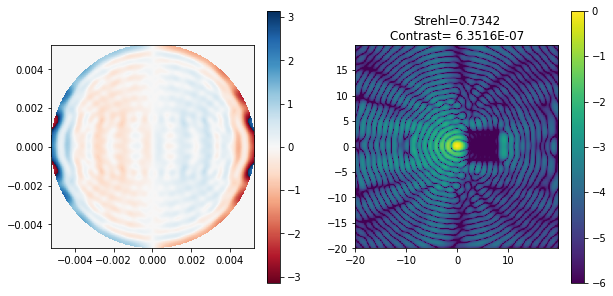

In [6]:
plt.subplot(1, 2, 1)
imshow_field(app_phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.subplot(1, 2, 2)
imshow_field(np.log10(imapp / imapp.max()), vmin=-6, grid=plot_grid)

### Step 3: Setting up the virtual model in TensorFlow.

In [7]:
import tensorflow as tf
import tensorflow.keras.backend as K

In [ ]:
tf.__version__

In [ ]:
# needed so that we can feed input wavefront into loss function
tf.python.framework_ops.disable_eager_execution() # for TF 2.2

In [8]:
# Constants needed for the contrast calculation
wf_amp = wf.amplitude
uv_grid = science_focal_grid.scaled(2 * np.pi/ wavelength)
M1 = np.exp(-1j * np.outer(uv_grid.separated_coords[1], pupil_grid.separated_coords[1]))
M2 = np.exp(-1j * np.outer(uv_grid.separated_coords[0], pupil_grid.separated_coords[0])).T
pweights = pupil_grid.weights
fweights = science_focal_grid.weights
D = dm.influence_functions.transformation_matrix.toarray()
app_field = app_amp * np.exp(1j * app_phase)
cent_ind = science_focal_grid.closest_to([0, 0])

In [9]:
# Function to Fraunhofer-propagate a batch of electric fields from pupil plane to science focal plane

@tf.function
def fraunhofer_tf(field):
    f = tf.reshape(field * pweights, (-1, M1.shape[1], M2.shape[0]))
    result = -1j * tf.einsum("ij,njk,kl->nil", M1, f, M2) / wavelength
    return tf.reshape(result, [-1, M1.shape[0] * M2.shape[1]])

In [10]:
@tf.function
def contrast_metric(x, phi_in):
    '''Function to calculate the gradient of the contrast w.r.t. the DM actuators.
    x: Batch tensor variable with actuator amplitudes of the DM in meters.
    phi_in: Batch of residual turbulence phase which is the input to the optical system.'''
    
    # Convert the phase input into an electric field
    E_in = tf.cast(wf_amp * tf.exp(1j * tf.cast(phi_in, tf.complex128)), tf.complex128, name="E_in")
  
    # Use the DM influence functions and actuator levels to determine the surface
    S = tf.linalg.matvec(D, x, name="dm_surface")
  
    # Calculate the electric field contribution from the DM
    dm_field = tf.exp(2j * (2 * np.pi / wavelength) * tf.cast(S, tf.complex128), name="dm_field")
    E_d = tf.math.multiply(E_in, dm_field, name="E_d")
    
    # Calculate the electric field contribution from the coronagraph
    E_c = tf.math.multiply(E_d, app_field, name="E_c")
  
    # Fraunhofer propagate the electric field to the focal plane
    E_f = fraunhofer_tf(E_c)
  
    # Calculate the focal plane intensity
    I_f = tf.square(tf.abs(E_f), name="I_f")
    
    # Calculate the focal plane power - this is the image
    p_f = tf.math.multiply(I_f, fweights, name="p_f")
  
    # Extract the intensities from pixels at the dark hole
    dh_intens = tf.math.reduce_sum(tf.math.multiply(p_f, dh_mask), axis=-1)
    
    # Return this as the metric to minimize                  
    return dh_intens

Testing the virtual model to see that the result matches the hcipy result.

In [48]:
wavefront_input = []
actuator_input = []
cost_func_results = []

for test in range(3):

    dm.flatten()
    dm.actuators = np.random.normal(0.0, 0.002, dm.actuators.shape) * 1e-6 # random normal distribution of act amps
    actuators = dm.actuators.copy()

    atmosphere.evolve_until(None) # reset atmosphere
    
    wfatms_tel = atmosphere.forward(wf_tel)
    wfatms = demag.forward(wfatms_tel)

    # Get WFS sensed wavefront
    # wffilt = propWFS.backward(spatial_filter.forward(propWFS(wfatms)))
    # wffilt.electric_field *= aperture(pupil_grid)
    # phase_input = wffilt.phase
    phase_input = wfatms.phase
    
    # Get estimated focal plane image
    img = prop(dm.forward(app.forward(wfatms))).power
    
    wavefront_input.append(phase_input.copy())
    actuator_input.append(dm.actuators.copy())
    cost_func_results.append(img[dz_ind].sum())

In [49]:
wavefront_input = np.asarray(wavefront_input)
actuator_input = np.asarray(actuator_input)
cost_func_results = np.asarray(cost_func_results)

In [50]:
test_metric = contrast_metric(actuator_input, wavefront_input)

In [51]:
test_metric.numpy()

array([68.601757 , 44.7763018, 53.6900278])

In [52]:
cost_func_results

array([68.601757 , 44.7763018, 53.6900278])

### Step 4: Create a dataset of residual-turbulence wavefronts to train on

In [ ]:
num_phasescreens = 3200

wf_dataset = []
for ps in range(num_phasescreens):
    atmosphere.evolve_until(None) # reset atmosphere
    
    phase_unwrap = atmosphere.phase_for(wavelength) # The unwrapped phase or wavefront opd in radians
    phase_field = Field(phase_unwrap, telescope_pupil_grid) # Convert to hcipy field and put it on the grid
    phase_field.grid = phase_field.grid.scaled(demag.magnification) # Demagnify grid down to instrument scale
    
    wf_dataset.append(phase_field) # append this to the dataset

wf_dataset = np.asarray(wf_dataset)
np.save("input_phases_unwrapped.npy", wf_dataset)

### Step 4: Create a custom loss function in TensorFlow

In [ ]:
# Custom loss function in wrapper to have access to input
def contrast_loss_wrapper(input_tensor):
    # input_tensor here is the unwrapped phase of the residual turbulence
    
    def contrast_loss_fn(y_true, y_pred):
        # Here y_pred are the predicted actuator values that should maximize contrast
        # y_true is unused
        contrast_loss = contrast_metric(y_pred, input_tensor)
        return contrast_loss
    
    return contrast_loss_fn

### Step 5: Create the neural network

In [ ]:
inputs = tf.keras.Input(shape=(65536,), name="wavefronts")
#x = tf.keras.layers.Dense(3200, activation="swish")(inputs)
#x = tf.keras.layers.Dropout(0.25)(x)
#x = tf.keras.layers.Dense(3200, activation="swish")(x)
#x = tf.keras.layers.Dropout(0.25)(x)
#x = tf.keras.layers.Dense(3200, activation="swish")(x)
#x = tf.keras.layers.Dropout(0.25)(x)
#x = tf.keras.layers.Dense(3200, activation="swish")(x)
#x = tf.keras.layers.Dropout(0.25)(x)
outputs = tf.keras.layers.Dense(625, activation="linear", kernel_initializer='zeros', name="actuators")(inputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile model with custom loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)
model.compile(loss=contrast_loss_wrapper(inputs), optimizer=optimizer)

### Step 6: Train the neural network

In [ ]:
input_phases = np.load("input_phases_unwrapped.npy")

In [ ]:
#input_phases /= 10.0

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
model.fit(input_phases, input_phases, batch_size=250, epochs=100, validation_split=0.01, callbacks=[callback], verbose=1)

In [ ]:
dm.actuators = np.zeros(dm.actuators.shape)

np.random.seed(2010203)
atmosphere.evolve_until(None)
# Make sure lag is accounted for
for loop in np.arange(0.001, 0.1, 0.001):
    atmosphere.evolve_until(loop)

atmosphere.t += 1
wfatms_tel = atmosphere.forward(wf_tel)
wfatms = demag.forward(wfatms_tel)

phase_input = wfatms.phase
phase_input = np.expand_dims(phase_input, axis=0)

predicted_acts = model(phase_input)

In [ ]:
pred_act_vals = K.eval(predicted_acts)[0]

In [ ]:
dm.actuators = pred_act_vals.copy()
img_cont = prop(app.forward(dm.forward(wfatms))).power
imshow_field(np.log10(img_cont / img_cont.max()), vmin=-6, grid=plot_grid)
plt.colorbar()

In [ ]:
flat_img = prop(app.forward(wfatms)).power

In [ ]:
cont_contrast = img_cont[dz_ind].mean() / img_cont[np.argmax(diff_lim_img)]

In [ ]:
flat_contrast = flat_img[dz_ind].mean() / flat_img[np.argmax(diff_lim_img)]

In [ ]:
cont_contrast

In [ ]:
flat_contrast

In [ ]:
model.save("linear_contrast_model.h5")

In [ ]:
del(model)